### Example: reconfiguring a mirror element made from a Totimorphic lattice 

In [3]:
import matplotlib.pyplot as plt
%matplotlib notebook
from matplotlib.animation import FuncAnimation

import numpy as np
import seaborn as sns

from LattyMorph.morphing import create_flat_3D_sheet
from LattyMorph.morphing.lattice_models.threeDim import Toti3D
from LattyMorph.optics.losses import get_loss

from tqdm import trange
import torch
from copy import deepcopy

Set up the mirror surface as a flat surface and then reconfigure it by bundling the reflected light into a desired focal point. This process can be continued to continuously change the focal point of the mirror.

In [5]:
xdim = 6
ydim = 6
model = create_flat_3D_sheet(xdim,ydim)
conf, orig = model.lattice_config()
configs = []
origins = []
configs.append(conf)
origins.append(orig['origin'].numpy().tolist())

light_direction = torch.Tensor([0,0,-1])
tgt_point = deepcopy(model.lattice[int(xdim/2)][int(ydim/2-1)].pointBprime.detach())
lossf = torch.nn.MSELoss()
    
for zloc in [120]:#, 96, 72, 48, 24, 12, 6]:
    detector_loc = torch.Tensor([int(xdim/2),int(ydim/2),zloc])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    pbar = trange(1)
    losses = []
    rec_losses = []
    counts = 0
    best_val = 1
    for j in pbar:
        while best_val > 5e-4:
            optimizer.zero_grad()
            valid = model.forward()
            if valid == False:
                print("Yikes!")
                break
            loss = get_loss(lossf, light_direction, detector_loc, model)
            # focal point loss
            rec_l = np.sqrt(deepcopy(loss.detach().numpy()))
            rec_losses.append(float(rec_l))
            # keep lattice from moving -> mid-point has to stay more or less fixed
            loss += 0.1*lossf(tgt_point, model.lattice[int(xdim/2)][int(ydim/2-1)].pointBprime)
            loss.backward()
            optimizer.step()
            conf, orig = model.lattice_config()
            configs.append(conf)
            origins.append(orig['origin'].numpy().tolist())
            losses.append(float(np.sqrt(deepcopy(loss.detach().numpy()))))
            # reduce learning rate after sufficient progress (not optimal)
            if rec_l < 0.005:
                for g in optimizer.param_groups:
                    g['lr'] = 0.0001
            if rec_l < best_val:
                best_val = rec_l
            pbar.set_description('Step {}: Current loss {:.5f}; Best loss {:.5f}'.format(counts, rec_l, best_val))
            counts += 1

    results = dict()

    results['loss'] = losses
    results['pointing_loss'] = rec_losses
    results['target'] = detector_loc.detach().numpy().tolist()
    results['origins'] = origins
    results['configs'] = configs
    results['best'] = float(best_val)

#     with open('results/Telescope_{}.json'.format(zloc), 'w') as outfile:
#         json.dump(results, outfile)

  0%|          | 0/1 [00:00<?, ?it/s]/home/dodo/git/final_latty/LattyMorph/LattyMorph/optics/lightrays.py:8: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at ../aten/src/ATen/native/Cross.cpp:62.)
  normal_bottom = torch.cross(lattice.pointB-lattice.pointA, lattice.pointC-lattice.pointA)
Step 5145: Current loss 0.00049; Best loss 0.00049: 100%|██████████| 1/1 [17:25<00:00, 1045.39s/it]


Visualize the morphing process

In [6]:
from LattyMorph.optics.lightrays import get_all_normal_vectors, get_all_midpoints, get_all_reflected_directions, get_closest_point

def plot_rays(ax, model, light_direction, detector_location):
    normals = get_all_normal_vectors(model)
    midpoints = get_all_midpoints(model)
    reflections = get_all_reflected_directions(light_direction, normals)
    
    dist = []
    for i in range(len(reflections)):
        dist.append(get_closest_point(detector_location, midpoints[i], reflections[i]))
    
    with torch.no_grad():
        for i in range(len(reflections)):
            ax.plot3D([midpoints[i][0], dist[i][0]], [midpoints[i][1], dist[i][1]], [midpoints[i][2], dist[i][2]], color = 'gold')

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.bbox'] = 'tight'

fig = plt.figure(figsize=plt.figaspect(1))
ax = fig.add_subplot(1, 1, 1, projection='3d')
axs = [ax]
sns.despine(ax=ax, bottom=True,top=True,left=True,right=True)
ln, = ax.plot3D([0], [0], [0])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax._axis3don = False

def init():
    return ln,

def update(kk):
    j = 0
    for ax in axs:
        ax.clear()
        ax.view_init(elev=30, azim = 90+kk*360/(700*2), roll = 0)
        with torch.no_grad():
            model_plt = Toti3D(configs[kk], origin = torch.Tensor(origins[kk]))
            model_plt.forward()
            model_plt.plot(ax=ax, xlim=(-0.,6), ylim=(-0.,6), zlim = (-0.,6), msize=1)
            plot_rays(ax, model_plt, light_direction, detector_loc)
            ax.plot3D([detector_loc[0]], [detector_loc[1]], [detector_loc[2]], marker= 'o', color = 'tomato', markersize = 4)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_zticks([])
            ax.set_zlim(0,125)
        ax._axis3don = False

    plt.tight_layout()

ani = FuncAnimation(fig, update, frames=np.arange(0,len(configs),2),
                    init_func=init, blit=True)

# ani.save('TotiWebb.gif')

<IPython.core.display.Javascript object>

In [7]:
from LattyMorph.optics.lightrays import get_all_normal_vectors, get_all_midpoints, get_all_reflected_directions, get_closest_point

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.bbox'] = 'tight'

fig = plt.figure(figsize=plt.figaspect(1))
ax = fig.add_subplot(1, 1, 1, projection='3d')
axs = [ax]
sns.despine(ax=ax, bottom=True,top=True,left=True,right=True)
ln, = ax.plot3D([0], [0], [0])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax._axis3don = False

def init():
    return ln,

def update(kk):
    j = 0
    for ax in axs:
        ax.clear()
        ax.view_init(elev=30, azim = 90+kk*360/(200*2), roll = 0)
        with torch.no_grad():
            model_plt = Toti3D(configs[kk], origin = torch.Tensor(origins[kk]))
            model_plt.forward()
            model_plt.plot(ax=ax, xlim=(-0.,6), ylim=(-0.,6), zlim = (-0.,6), msize=1)
#             plot_rays(ax, model_plt, light_direction, detector_loc)
            ax.plot3D([detector_loc[0]], [detector_loc[1]], [detector_loc[2]], marker= 'o', color = 'tomato', markersize = 4)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_zticks([])
            ax.set_zlim(0,0.05)
        ax._axis3don = False

    plt.tight_layout()

ani = FuncAnimation(fig, update, frames=np.arange(0,len(configs),2),
                    init_func=init, blit=True)

# ani.save('TotiWebb.gif')

<IPython.core.display.Javascript object>

Use the mirror to image. Here, we pretend that we are imaging Pluto (if it had the same size and distance to Earth as the Moon)

First, the image to be imaged:

In [8]:
from PIL import Image
import numpy as np
def get_image(image_z, light_direction, model):
    normals = get_all_normal_vectors(model)
    midpoints = get_all_midpoints(model)
    reflections = get_all_reflected_directions(light_direction, normals)
    
    x,y = [], []
    
    for i in range(len(reflections)):
        lambdas = (image_z - midpoints[i][-1])/reflections[i][-1]
        new_vec = midpoints[i] + lambdas * reflections[i]
        x.append(float(new_vec[0].detach().numpy()))
        y.append(float(new_vec[1].detach().numpy()))
    
    return x,y

def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    img = img.resize((200, 200))
    data = np.asarray( img, dtype="int32" )
    return data

image = load_image('nh_pluto_10.png') 


xmax, ymax, _ = np.shape(image)
plt.figure()
plt.imshow(image)
plt.xticks([])
plt.yticks([])

<IPython.core.display.Javascript object>

([], [])

Set the dimensions of the object...

In [9]:
extension = 1700*1e3

# Moon 0.5
# Jupiter 0.01
theta = 0.5 /180 * np.pi

dist = extension/np.arctan(theta/2)
print(dist)
def xy_to_angle(x,y,imwidth):
    dx = (x-imwidth)/imwidth*extension
    dy = -(y-imwidth)/imwidth*extension
    vec = torch.Tensor([dx,dy,dist])
    vec = vec/vec.norm()
    
    return -vec

389613773.22618055


Do the imaging...

In [66]:
xvals = []
yvals = []
colors = []

for i in trange(len(image)):
    for j in range(len(image[i])):
        if np.sum(image[i][j][:3]) == 0:
            continue
        else:
            vec = xy_to_angle(j,i, 100)
            x,y = get_image(120, vec, model)
            xvals.append(x)
            yvals.append(y)
            colors.append(tuple(image[i][j]/255))

100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [03:24<00:00,  1.02s/it]


And plot it!

<IPython.core.display.Javascript object>


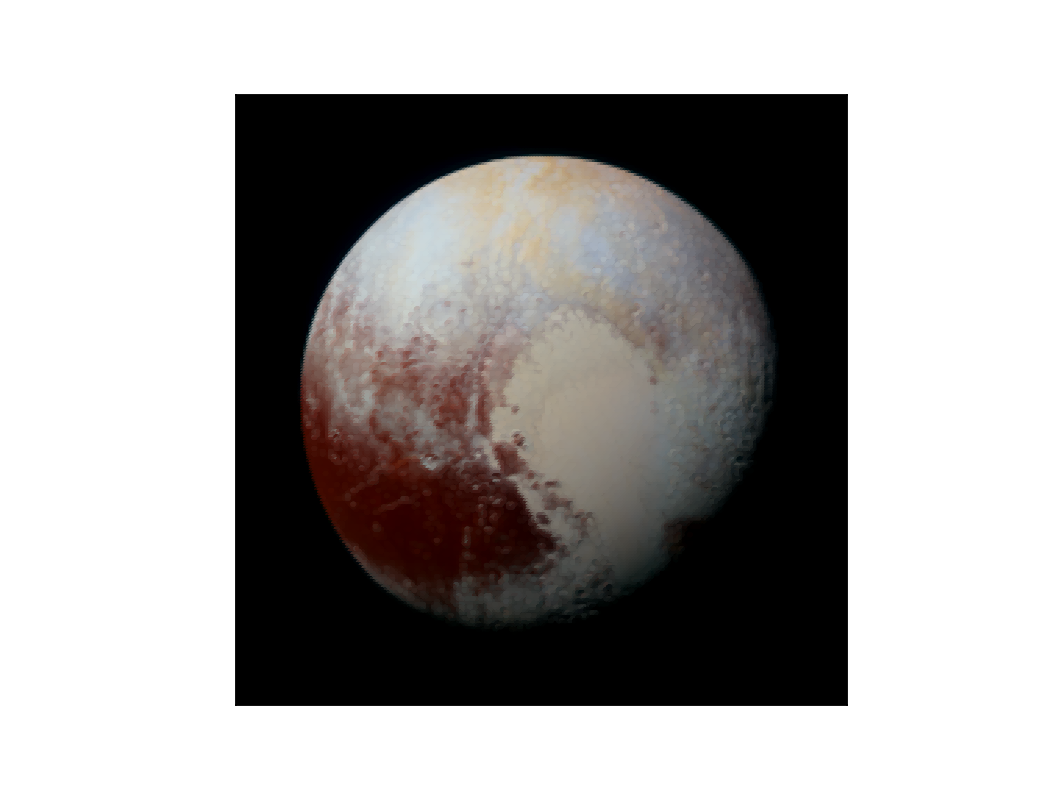

In [67]:
plt.figure()

x = []
y = []
c = []
counts = 0
for i in range(len(xvals)):
    x += (-np.array(xvals[i])).tolist()
    y += (-np.array(yvals[i])).tolist()
    c += [colors[i]]*len(xvals[i])
plt.rcParams['axes.facecolor'] = 'black'
plt.scatter(x,y, c = np.array(c), s=2, alpha = 0.05)
plt.xticks([])
plt.yticks([])
# plt.xlim(2.4,3.6)
# plt.ylim(-3.6, -2.4)
plt.gca().set_aspect('equal')
plt.show()

We can do the same pretending that Pluto has the dimension and distance of Jupiter. In that case, we see that we would need to change the mirror design to further increase the field of view.

In [61]:
extension = 1700*1e3

# Moon 0.5
# Jupiter 0.01
theta = 0.01 /180 * np.pi

dist = extension/np.arctan(theta/2)
print(dist)
def xy_to_angle(x,y,imwidth):
    dx = (x-imwidth)/imwidth*extension
    dy = -(y-imwidth)/imwidth*extension
    vec = torch.Tensor([dx,dy,dist])
    vec = vec/vec.norm()
    
    return -vec

19480565083.898983


In [62]:
xvals = []
yvals = []
colors = []

for i in trange(len(image)):
    for j in range(len(image[i])):
        if np.sum(image[i][j][:3]) == 0:
            continue
        else:
            vec = xy_to_angle(j,i, 100)
            x,y = get_image(120, vec, model)
            xvals.append(x)
            yvals.append(y)
            colors.append(tuple(image[i][j]/255))

100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [03:29<00:00,  1.05s/it]


<IPython.core.display.Javascript object>


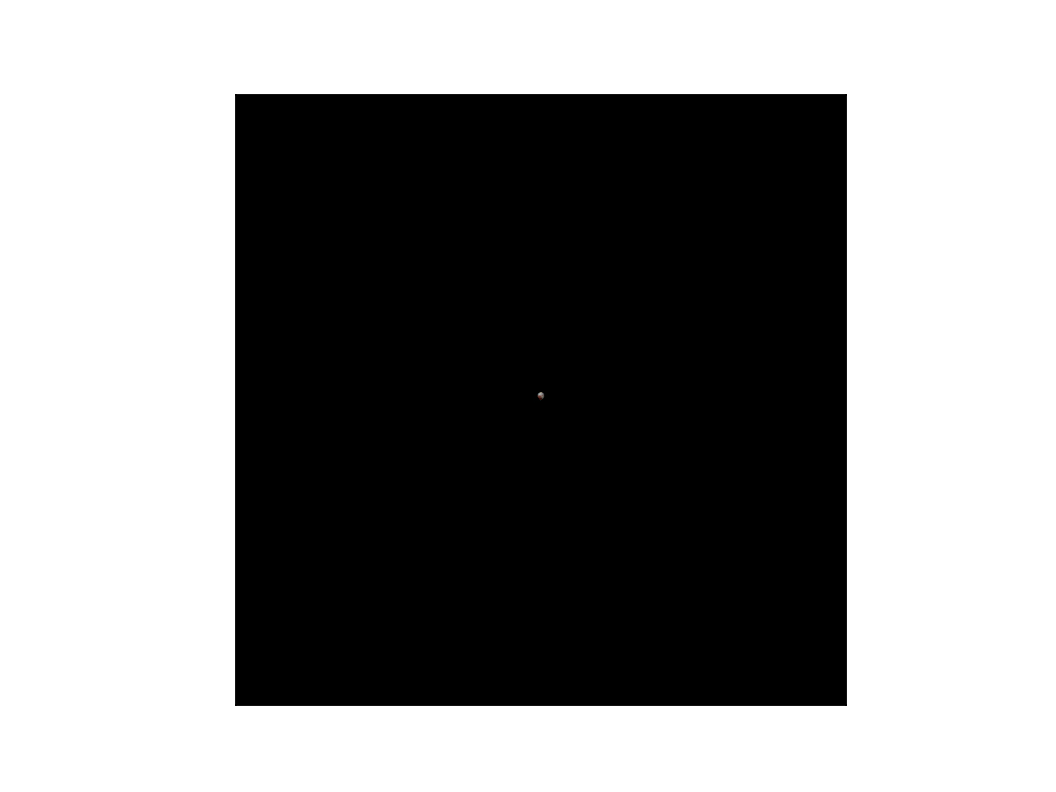

In [64]:
plt.figure()

x = []
y = []
c = []
counts = 0
for i in range(len(xvals)):
    x += (-np.array(xvals[i])).tolist()
    y += (-np.array(yvals[i])).tolist()
    c += [colors[i]]*len(xvals[i])
plt.rcParams['axes.facecolor'] = 'black'
plt.scatter(x,y, c = np.array(c), s=2, alpha = 0.05)
plt.xticks([])
plt.yticks([])

# comment out to zoom in
plt.xlim(-3.6,-2.4)
plt.ylim(-3.6, -2.4)

plt.gca().set_aspect('equal')
plt.show()